In [1]:
import numpy as np
import matplotlib.pyplot as plt

P_triple = 0.51795e6
T_triple = 216.592

#Smith van Ness Abbot
Tc = 304.2 #K
Pc = 73.83e5 
w = 0.224

def Pfus(T):
    #Baseado em Span e Wagner CO2
    Pfus = P_triple*(1+1955.5390*0.75*((T/T_triple)-1)+2055.4593*((T/T_triple)-1)**2)
    return Pfus

def Tfus(P):
    def Res1(T):
        return Pfus(T)-P
    answer = opt.newton(Res1,T_triple,maxiter = 10000)
    return answer

def Psublim(T):
    #Baseado em Span e Wagner CO2
    Psublim = P_triple*np.exp((T_triple/T)*(-14.740846*(1-(T/T_triple))+2.4327015*((1-(T/T_triple))**2)-5.3061778*((1-(T/T_triple))**3)))
    
    return Psublim

def Tsublim(P):
    def Res2(T):
        return Psublim(T)-P
    answer = opt.newton(Res2,T_triple,maxiter = 10000)
    return answer

def Psat(T):
    Psat = 10 ** (7.5322 - (835.06)/(268.223+T-273.15)) #Dortmund database CO2
    Psat = Psat * 133.322365
    return Psat


In [2]:
T_sublim = np.linspace(100,T_triple,500)
T_fus = np.linspace(T_triple, 400,500)
T_sat = np.linspace(T_triple, Tc, 500)

In [3]:
from scipy import optimize as opt

R = 8.3144598
T_ref = Tc

omega=0.086640
b = (omega*R*Tc)/Pc

def T_preos(P,V):
    
    def Res(T):
        Res = ((R*T)/(V-b) - a(T)/(V*(V+b)))-P
        return (Res)
    
    answer = opt.newton(Res,P*V/R,maxiter = 10000)

    return answer

def P_preos(T,V):
    return (R*T)/(V-b) - a(T)/(V*(V+b))

def a(T):
    return ((R*R*Tc*Tc*0.427480/Pc)*(1+((0.480+1.574*w-0.176*w*w)*(1-(np.sqrt(T/Tc)))))**2)

def calcV(P,T):
    
    eps = 1
    sig = 0
    
    kappa_ = 0.48508 + 1.55171*w-0.15613*w*w
    theta = (R*R*Tc*Tc*0.427480/Pc)*(1+kappa_-kappa_*(T/Tc)**0.5)**2
    
    c1=1
    c2=-R*T/P
    c3=-((R*T/P)+b)*b+theta/P
    c4=-(b*theta/P)
    
    V=np.roots([c1,c2,c3,c4])
    
    
    for i in range(len(V)):
        if (V[i]<=b):
            V[i] = np.nan
        elif(abs(V[i].imag)>=1e-5):
            V[i] = np.nan
    
    Vl = np.nanmin(V)
    Vv = np.nanmax(V)
    return (Vl,Vv)

def phiv(P,T):
    c1=P
    c2=-R*T
    c3=-b*R*T-P*b*b+a(T)
    c4=-a(T)*b
    V=np.roots([c1,c2,c3,c4])
    Vv= max(V)
    return np.exp(((P*Vv)/(R*T))-1-np.log(((P*Vv)/(R*T))-(b*P)/(R*T))- (a(T)/(b*R*T))*np.log((((P*Vv)/(R*T))+ (b*P)/(R*T))/((P*Vv)/(R*T)))), Vv

def phil(P,T):
    c1=P
    c2=-R*T
    c3=-b*R*T-P*b*b+a(T)
    c4=-a(T)*b
    V=np.roots([c1,c2,c3,c4])
    Vl= min (V)
    return np.exp(((P*Vl)/(R*T))-1-np.log(((P*Vl)/(R*T))-(b*P)/(R*T))- (a(T)/(b*R*T))*np.log((((P*Vl)/(R*T))+ (b*P)/(R*T))/((P*Vl)/(R*T)))),Vl

def calc_H(T,P,V):
    
    eps = 1
    sig = 0
    
    H_ideal = (-1.5816e-7/4)*((T**4)-(T_ref**4))+(1.473739e-4/3)*((T**3)-(T_ref**3))-(2.0981e-4/2)*((T**2)-(T_ref**2))+2.803514e1*(T-T_ref)
    
    psi = (1/(b*(eps-sig)))*np.log((V+eps*b)/(V+sig*b))
    kappa_ = 0.48508 + 1.55171*w-0.15613*w*w
    
    theta = (R*R*Tc*Tc*0.427480/Pc)*(1+kappa_-kappa_*(T/Tc)**0.5)**2
    theta_ = -(R*R*Tc*Tc*0.427480/Pc)*kappa_*(((1+kappa_)/((T/Tc)**0.5))-kappa_)/Tc
    
    H_res = P*V-R*T+(T*theta_-theta)*psi
        
    return H_res+H_ideal

def calc_S(T,P,V):
    
    eps = 1
    sig = 0
    
    S_ideal = (-1.5816e-7/3)*((T**3)-(T_ref**3))+(1.473739e-4/2)*((T**2)-(T_ref**2))-(2.0981e-4)*((T)-(T_ref))+2.803514e1*np.log(T/T_ref) - R*np.log(P/Pc)
    
    psi = (1/(b*(eps-sig)))*np.log((V+eps*b)/(V+sig*b))
    kappa_ = 0.48508 + 1.55171*w-0.15613*w*w
    
    theta = (R*R*Tc*Tc*0.427480/Pc)*(1+kappa_-kappa_*(T/Tc)**0.5)**2
    theta_ = -(R*R*Tc*Tc*0.427480/Pc)*kappa_*(((1+kappa_)/((T/Tc)**0.5))-kappa_)/Tc
    
    S_res = R*np.log(P*(V-b)/(R*T)) + theta_*psi
    return S_res+S_ideal

def Psat_eos(T,P_iguess):
    
    RES=1
    TOL=1e-9
    MAX=1000
    i=0
    P=P_iguess
    
    while(RES>TOL and i<MAX): 
        
        valor_phi_L, Vol_L = phil(P,T)
        valor_phi_V, Vol_V = phiv(P,T)
        
        P=P*(valor_phi_L/valor_phi_V)
        RES=abs((valor_phi_L/valor_phi_V)-1.)
        i=i+1
        
    H_L=calc_H(T,P,Vol_L)
    H_V=calc_H(T,P,Vol_V)
    
    S_L=calc_S(T,P,Vol_L)
    S_V=calc_S(T,P,Vol_V)  
        
    return P, Vol_L, Vol_V, H_L, H_V, S_L, S_V

def Tsat(P,T_iguess):
    
    RES=1
    TOL=1e-9
    MAX=1000
    i=0
    T=T_iguess
    
    while(RES>TOL and i<MAX): 
        
        valor_phi_L, Vol_L = phil(P,T)
        valor_phi_V, Vol_V = phiv(P,T)
        
        T=T*(valor_phi_L/valor_phi_V)**-0.1
        RES=abs((valor_phi_L/valor_phi_V)-1.)
        i=i+1
        
    H_L=calc_H(T,P,Vol_L)
    H_V=calc_H(T,P,Vol_V)
    
    S_L=calc_S(T,P,Vol_L)
    S_V=calc_S(T,P,Vol_V)  
        
    return T, Vol_L, Vol_V, H_L, H_V, S_L, S_V

def isotherm_T_lt_Tc(T,V):
    Psat, V_l, V_v,_,_,_,_ = P_sat(T,1e5)
    if (V>V_l) and (V<V_v):
        pressure = Psat
    else:
        pressure = P_preos(T,V)
    return (pressure)

def isotherm_T_solid(T,V):
    
    P_fus = Pfus(T)
    V_s = solid_volume(T,P_fus)
    V_l,_ = calcV(P_fus,T)
    Psat, V2_l, V_v,_,_,_,_ = P_sat(T,1e5)
    
    if (V<V_s):
        pressure = solid_pressure(T,V)
    elif (V>V_s) and (V<V_l):
        pressure = P_fus
    elif(V>V_l) and (V<V2_l):
        pressure = P_preos(T,V)
    elif (V>V2_l) and (V<V_v):
        pressure = Psat
    else:
        pressure = P_preos(T,V)
    return (pressure)

In [4]:
from scipy import integrate as integrate

def Pfus_deltas(T):
    n = 100
    
    integrand=integrate.ode(deltaH_deltaV)
    y0 = P_triple
    t0 = T_triple
    
    r = integrand.set_integrator('zvode', method='bdf')
    r.set_initial_value(y0, t0)
    t1 = T
    dt = (T-T_triple)/n
    while r.successful() and r.t < t1:
        r.integrate(r.t+dt)
    
    return np.real(r.y[0]),deltaH_deltaV2(T,r.y[0])


def deltaH_deltaV(T,P0):
    P = np.real(P0)
    V_liquid, _ = np.real(calcV(P,T))
    H_liq = calc_H(T,P,V_liquid)
    deltaH = solid_enthalpy_fromvapor(T,Psublim(T)) - H_liq
    return0 = (deltaH/(T*(solid_volume(T,P)-V_liquid)))
    return return0, solid_enthalpy_fromvapor(T,Psublim(T))

def deltaH_deltaV2(T,P0):
    P = np.real(P0)
    V_liquid, _ = np.real(calcV(P,T))
    H_liq = calc_H(T,P,V_liquid)
    deltaH = solid_enthalpy_fromvapor(T,Psublim(T)) - H_liq
    return0 = (deltaH/((solid_volume(T,P)-V_liquid)))
    return solid_entropy_fromvapor(T,Psublim(T))

In [5]:
def solid_volume(T,P):
    
    a_ = (5.540 + 4.679e-6*(T**2))*1e-10
    kappa = (1.259808e-10-5.207279e-14*T+3.218216e-15*T**2)*0.25
    V = ((a_**3)/4)*6.023e23*np.exp(-kappa*(P-101325))

    return V

def solid_temperature(V,P):
    def Res3(T):
        return solid_volume(T,P)-V
    answer = opt.brentq(Res3,T_triple*0,5*Tc,xtol=1e-12, rtol = 4e-15,maxiter = 100000)
    return answer

def int_dV_dT_Pcte(T,P,P0):
    
    a_ = (5.540 + 4.679e-6*(T**2))*1e-10
    kappa = (1.259808e-10-5.207279e-14*T+3.218216e-15*T**2)*0.25
    da_dT = 1e-10*2*4.679e-6*T
    
    dV_dT_Pcte = (3*(a_**2)/4)*6.023e23*np.exp(kappa*101325)*(1/kappa)*da_dT*(np.exp(-kappa*P0)-np.exp(-kappa*P))
    
    return dV_dT_Pcte

def int_v_dP(T,P,P0):
    
    a_ = (5.540 + 4.679e-6*(T**2))*1e-10
    kappa = (1.259808e-10-5.207279e-14*T+3.218216e-15*T**2)*0.25
    
    int_v_dP = ((6.023e23 * np.exp(kappa*101325) * a_**3)/(4*kappa))*(np.exp(-kappa*P0)-np.exp(-kappa*P))
    
    return int_v_dP

def solid_pressure(T,V):

    a_ = (5.540 + 4.679e-6*(T**2))*1e-10
    kappa = (1.259808e-10-5.207279e-14*T+3.218216e-15*T**2)*0.25
    P = 101325. - (1/kappa)*np.log(V/((a_**3)*6.023e23/4))
    
    return P

def solidification_enthalpy(T,P):
    
    dPfus_dT = (Pfus(T+0.00001)-Pfus(T-0.00001))/0.00002
    
    V_liquid, _ = calcV(P,T)
    deltaH = T*(solid_volume(T,P)-V_liquid)*dPfus_dT
        
    return deltaH

def solidification_entropy(T,P):
  
    dPfus_dT = (Pfus(T+0.00001)-Pfus(T-0.00001))/0.00002
    
    V_liquid, V_vapor = calcV(P,T)

    deltaS = (solid_volume(T,P)-V_liquid)*dPfus_dT

    return deltaS

def sublimation_enthalpy(T,P):
    _, V_vapor = np.real(calcV(P,T))
    dPsublim_dT = (Psublim(T+0.0001)-Psublim(T-0.0001))/0.0002
    
    deltaH = T*(solid_volume(T,P)-V_vapor)*dPsublim_dT
    return deltaH

def sublimation_entropy(T,P):
    _, V_vapor = np.real(calcV(P,T))
    dPsublim_dT = (Psublim(T+0.0001)-Psublim(T-0.0001))/0.0002
    
    deltaS = (solid_volume(T,P)-V_vapor)*dPsublim_dT
    return deltaS

def solid_enthalpy_fromliquid(T,P):
    
    P_fus =  Pfus(T)
    V_liquid, _ = calcV(P_fus,T) 
    H_liquid = calc_H(T,P_fus,V_liquid)
    
    H_S = H_liquid + solidification_enthalpy(T,P_fus) + int_v_dP(T,P,P_fus) -T*int_dV_dT_Pcte(T,P,P_fus)

    return(H_S)

def solid_entropy_fromliquid(T,P_):
    
    P_fus =  Pfus(T)
    V_liquid, _ = calcV(P_fus,T) 
    S_liquid = calc_S(T,P_fus,V_liquid)
    
    S_S = S_liquid + solidification_entropy(T,P_fus) -int_dV_dT_Pcte(T,P_,P_fus)
    return(S_S)

def solid_enthalpy_fromvapor(T,P):
    
    P_sublim =  Psublim(T)
    _, V_vapor = calcV(P_sublim,T)
    
    H_vapor = calc_H(T,P_sublim,V_vapor)
    
    H_S = H_vapor + sublimation_enthalpy(T,P_sublim) + int_v_dP(T,P,P_sublim) -T*int_dV_dT_Pcte(T,P,P_sublim)

    return(H_S)

def solid_entropy_fromvapor(T,P_):
    
    P_sublim =  Psublim(T)
    _, V_vapor = calcV(P_sublim,T)
    
    S_vapor = calc_S(T,P_sublim,V_vapor)
    
    S_S = S_vapor + sublimation_entropy(T,P_sublim) -int_dV_dT_Pcte(T,P_,P_sublim)

    return(S_S)

In [6]:
#isóbaras
def isobar_all(P,V):
    if(P>Pc):
        T_fus_ = Tfus(P)
        V_s1 = solid_volume(T_fus_,P)
        V_l1, _ = calcV(P,T_fus_)
        if(V<=V_s1):
            temperature = solid_temperature(V,P)
            if(temperature<=T_triple):
                entropy = solid_entropy_fromvapor(temperature,P)
            else:
                entropy = solid_entropy_fromliquid(temperature,P)
        elif (V>V_l1):
            temperature = T_preos(P,V)
            entropy = calc_S(temperature,P,V)
        else:
            temperature = T_fus_
            entropy = calc_S(temperature,P,V_l1) + ((V-V_l1)/(V_s1-V_l1))*(solid_entropy_fromliquid(temperature,P)-calc_S(temperature,P,V_l1))
    elif(P<=P_triple):
        T_sublim_ = Tsublim(P)
        V_s2 = solid_volume(T_sublim_,P)
        _, V_v1 = calcV(P,T_sublim_)
        if(V<=V_s2):
            temperature = solid_temperature(V,P)
            if(temperature<=T_triple):
                entropy = solid_entropy_fromvapor(temperature,P)
            else:
                entropy = solid_entropy_fromliquid(temperature,P)
        elif (V>V_v1):
            temperature = T_preos(P,V)
            entropy = calc_S(temperature,P,V)
        else:
            temperature = T_sublim_
            entropy = calc_S(temperature,P,V_v1) + ((V-V_v1)/(V_s2-V_v1))*(solid_entropy_fromvapor(temperature,P)-calc_S(temperature,P,V_v1))
    elif(P>P_triple):
        T_fus_ = Tfus(P)
        V_s1 = solid_volume(T_fus_,P)
        V_l1, _ = calcV(P,T_fus_)
        T_sat_, V_l2, V_v2,_,_,_,_ = Tsat(P,T_triple)
        if(V<=V_s1):
            temperature = solid_temperature(V,P)
            if(temperature<=T_triple):
                entropy = solid_entropy_fromvapor(temperature,P)
            else:
                entropy = solid_entropy_fromliquid(temperature,P)
        elif(V>V_s1) and (V<=V_l1):
            temperature = T_fus_
            entropy = calc_S(temperature,P,V_l1) + ((V-V_l1)/(V_s1-V_l1))*(solid_entropy_fromliquid(temperature,P)-calc_S(temperature,P,V_l1))
        elif (V>V_l1) and (V<=V_l2):
            temperature = T_preos(P,V)
            entropy = calc_S(temperature,P,V)
        elif (V>V_v2):
            temperature = T_preos(P,V)
            entropy = calc_S(temperature,P,V)
        else:
            temperature = T_sat_
            entropy = calc_S(temperature,P,V_l2) + ((V-V_l2)/(V_v2-V_l2))*(calc_S(temperature,P,V_v2)-calc_S(temperature,P,V_l2))
    return temperature, entropy

def isobar_P_lt_Pc(P,V):
    T_sat_, V_l, V_v,_,_,_,_ = Tsat(P,100)
    if (V>V_l) and (V<V_v):
        temperature = T_sat_
    else:
        temperature = T_preos(P,V)
    return (temperature)

def isobar_P_solid(T,V):
    P_fus, H_s = Pfus_deltas(T)
    V_s = solid_volume(T,P_fus)
    V_l,_ = calcV(P_fus,T)
    H_l = calc_H(T,P_fus,V)
    Psat, V2_l, V_v, H2_l, H_v,_,_ = P_sat(T,1e5)
    if (V<V_s):
        pressure = solid_pressure(T,V)
        enthalpy = solid_enthalpy_fromvapor(T,pressure)
    elif (V>V_s) and (V<V_l):
        pressure = P_fus
        enthalpy = H_l + ((V-V_l)/(V_s-V_l))*(H_s-H_l)
    elif(V>V_l) and (V<V2_l):
        pressure = P_preos(T,V)
        enthalpy = calc_H(T,pressure,V)
    elif (V>V2_l) and (V<V_v):
        pressure = Psat
        enthalpy = H2_l + ((V-V_l)/(V_v-V_l))*(H_v-H2_l)
    else:
        pressure = P_preos(T,V)
        enthalpy = calc_H(T,pressure,V)
    return pressure, enthalpy

In [7]:
V_grid1 = np.logspace(-4.5915,-1,1000)
V_grid2 = np.logspace(-4.5915,-2,1000)
V_grid3 = np.logspace(-4.5915,-2,1000)
V_grid4 = np.logspace(-4.5915,-2,1000)

T_isobar = np.zeros(1000)
T_isobar_solid = np.zeros(1000)
T_isobar_critical = np.zeros(1000)
T_isobar_supercritical=np.zeros(1000)

S_isobar = np.zeros(1000)
S_isobar_solid = np.zeros(1000)
S_isobar_critical = np.zeros(1000)
S_isobar_supercritical = np.zeros(1000)

S_l = np.zeros(len(T_sat))
S_v = np.zeros(len(T_sat))
S_s = np.zeros(len(T_fus))
S_l_fus = np.zeros(len(T_fus))

V_l_fus = np.zeros(len(T_fus))
V_v_sublim = np.zeros(len(T_fus))
T_fus_grid = np.zeros(len(T_fus))

S_s_sublim = np.zeros(len(T_sublim))
S_v_sublim = np.zeros(len(T_sublim))

P_fus_grid = np.zeros(len(T_sat))
P_sat_ = np.zeros(len(T_sat))

T_sat_eos = np.zeros(len(T_sat))
P_guess = 1e4

for i in range(len(T_sat)):
#    V_s[i] = solid_volume(T_fus[i],Pfus(T_fus[i]))
#    V_s_sublim[i] = solid_volume(T_sublim[i],Psublim(T_sublim[i]))
    P_fus_grid[i] = Pfus(T_fus[i])
    V_l_fus[i], _ = calcV(P_fus_grid[i],T_fus[i])
    S_l_fus[i] = calc_S(T_fus[i],P_fus_grid[i],V_l_fus[i])
    S_s[i] = solid_entropy_fromliquid(T_fus[i], P_fus_grid[i])
    
    _, V_v_sublim[i] = calcV(Psublim(T_sublim[i]),T_sublim[i])
    S_v_sublim[i] = calc_S(T_sublim[i],Psublim(T_sublim[i]),V_v_sublim[i])
    S_s_sublim[i] = solid_entropy_fromvapor(T_sublim[i],Psublim(T_sublim[i]))
    

    P_sat_[i], _, _, _, _, S_l[i], S_v[i] = Psat_eos(T_sat[i],P_guess)
    P_guess =  P_sat_[i]

for i in range(len(V_grid1)):

    T_isobar[i], S_isobar[i] = isobar_all(Pc*0.3,V_grid2[i])
    # = calc_S(T_isobar[i],Pc*0.3,V_grid1[i])
        
    T_isobar_solid[i], S_isobar_solid[i] = isobar_all(P_triple*0.3,V_grid1[i])
    # = calc_S(T_isobar_solid[i],P_triple*0.3,V_grid2[i])
    
    T_isobar_critical[i], S_isobar_critical[i] = isobar_all(Pc,V_grid3[i])
    # = calc_S(T_isobar_critical[i],Pc,V_grid3[i])
    
    T_isobar_supercritical[i],S_isobar_supercritical[i] = isobar_all(Pc*10,V_grid4[i])
    # = calc_S(T_isobar_supercritical[i],Pc*3,V_grid4[i])


/home/medeirosfa/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
/home/medeirosfa/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
/home/medeirosfa/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/medeirosfa/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
/home/medeirosfa/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
/home/medeirosfa/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:58: ComplexWarning: Casting complex values to real discards the imaginary part


/home/medeirosfa/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home/medeirosfa/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


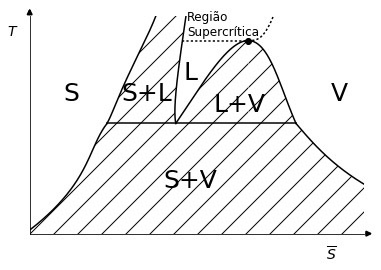

In [12]:
plt.plot(S_l,T_sat,color='k')
plt.plot(S_v,T_sat,color='k')
plt.plot(S_l_fus,T_fus,color='k')
plt.plot(S_s,T_fus,color='k')

plt.plot(S_v_sublim,T_sublim,color='k')
plt.plot(S_s_sublim,T_sublim,color='k')

plt.plot([S_s[0],S_v[0]],[T_triple,T_triple],color='k')

plt.ylim(100,330)
plt.xlim(-150,50)

plt.scatter(calc_S(Tc,Pc,calcV(Pc,Tc)[0]),Tc,color='k')

#Layout
ax = plt.gca()

xlabel = '$\overline{S}$'
ylabel = '$T$'

arrowprops = dict(arrowstyle='<|-', facecolor='black',lw=2)
arrow_length = 10

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_yticklabels([])
ax.set_xticklabels([])

t = ax.spines['bottom'].get_transform()
xy, xycoords = [1, 0], ('axes fraction', t)
xytext, textcoords = [arrow_length, 0], ('offset points', t)

xarrow = ax.annotate('', xy, xycoords=xycoords, xytext=xytext, 
                        textcoords=textcoords, ha='left', va='center',arrowprops=arrowprops)

t = ax.spines['left'].get_transform()
xy, xycoords = [1, 0], ('axes fraction', t)
xytext, textcoords = [arrow_length, 0], ('offset points', t)

yarrow = ax.annotate('', xy[::-1], xycoords=xycoords[::-1], 
                        xytext=xytext[::-1], textcoords=textcoords[::-1], ha='center', va='center', arrowprops=arrowprops)


plt.xlabel(xlabel,fontsize=14)
plt.ylabel(ylabel,rotation=0,fontsize=14)

ax.yaxis.set_label_coords(-0.05,0.9)
ax.xaxis.set_label_coords(0.9,-0.05)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    labelbottom='off') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off

ax.fill_between(S_l, T_triple, T_sat, facecolor='white', alpha=0.,
                label='1 sigma range', hatch = '/')

ax.fill_between(S_v, T_triple, T_sat, facecolor='white', alpha=0.,
                label='1 sigma range', hatch = '/')

ax.fill_between(S_s_sublim,0, T_sublim, facecolor='white', alpha=0.5,
                label='1 sigma range', hatch = '/')

ax.fill_between(S_v_sublim, 0, T_sublim, facecolor='white', alpha=0.5,
                label='1 sigma range', hatch = '/')

ax.fill_between([S_s[0],S_v[0]], 0,T_triple, facecolor='white', alpha=0.5,
                label='1 sigma range', hatch = '/')

ax.fill_betweenx(T_fus,S_s, S_l_fus, facecolor='white', alpha=0.5,
                label='1 sigma range', hatch = '/')

plt.plot([calc_S(Tc,Pfus(Tc),calcV(Pfus(Tc),Tc)[0]),calc_S(Tc,Pc,calcV(Pc,Tc)[0])],[Tc,Tc],ls=':',color='k')


S_grid_new = list()
T_isobar_critical_new = list()

for i in range(len(V_grid3)):
    if T_isobar_critical[i]>Tc:
        S_grid_new.append(calc_S(T_isobar_critical[i],Pc,V_grid3[i]))
        T_isobar_critical_new.append(T_isobar_critical[i])

plt.plot(S_grid_new,T_isobar_critical_new,color='k', ls=':')

textbox1 = 'V'
textbox2 = 'L'
textbox3 = 'S'
textbox4 = 'L+V'
textbox5 = 'S+V'
textbox6 = 'S+L'
textbox7 = r'Região'+'\n'+'Supercrítica'


ax.text(0.90, 0.7, textbox1, transform=ax.transAxes, fontsize=25,
        verticalalignment='top')

ax.text(0.46, 0.8, textbox2, transform=ax.transAxes, fontsize=25,
        verticalalignment='top')

ax.text(0.10, 0.7, textbox3, transform=ax.transAxes, fontsize=25,
        verticalalignment='top')

ax.text(0.55, 0.65, textbox4, transform=ax.transAxes, fontsize=25,
        verticalalignment='top')

ax.text(0.4, 0.3, textbox5, transform=ax.transAxes, fontsize=25,
        verticalalignment='top')

ax.text(0.275, 0.7, textbox6, transform=ax.transAxes, fontsize=25,
        verticalalignment='top',rotation=0)

ax.text(0.47, 0.90, textbox7, transform=ax.transAxes, fontsize=12,
        verticalalignment='bottom',rotation=0)

plt.show()

/home/medeirosfa/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


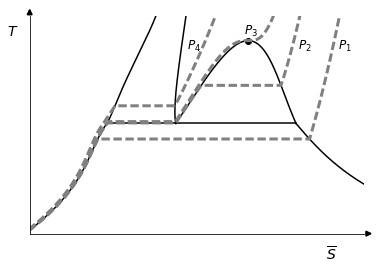

In [11]:
plt.plot(S_l,T_sat,color='k')
plt.plot(S_v,T_sat,color='k')
plt.plot(S_l_fus,T_fus,color='k')
plt.plot(S_s,T_fus,color='k')

plt.plot(S_v_sublim,T_sublim,color='k')
plt.plot(S_s_sublim,T_sublim,color='k')

plt.plot([S_s[0],S_v[0]],[T_triple,T_triple],color='k')

plt.ylim(100,330)
plt.xlim(-150,50)

plt.scatter(calc_S(Tc,Pc,calcV(Pc,Tc)[0]),Tc,color='k')

plt.plot([T_triple,T_triple],[S_s[0],S_v[0]],color='k',ls='-')

ax = plt.gca()

xlabel = r'$\overline{S}$'
ylabel = '$T$'

arrowprops = dict(arrowstyle='<|-', facecolor='black',lw=2)
arrow_length = 10

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_yticklabels([])
ax.set_xticklabels([])

t = ax.spines['bottom'].get_transform()
xy, xycoords = [1, 0], ('axes fraction', t)
xytext, textcoords = [arrow_length, 0], ('offset points', t)

xarrow = ax.annotate('', xy, xycoords=xycoords, xytext=xytext, 
                        textcoords=textcoords, ha='left', va='center',arrowprops=arrowprops)

t = ax.spines['left'].get_transform()
xy, xycoords = [1, 0], ('axes fraction', t)
xytext, textcoords = [arrow_length, 0], ('offset points', t)

yarrow = ax.annotate('', xy[::-1], xycoords=xycoords[::-1], 
                        xytext=xytext[::-1], textcoords=textcoords[::-1], ha='center', va='center', arrowprops=arrowprops)


plt.xlabel(xlabel,fontsize=14)
plt.ylabel(ylabel,rotation=0,fontsize=14)

ax.yaxis.set_label_coords(-0.05,0.9)
ax.xaxis.set_label_coords(0.9,-0.05)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    labelbottom='off') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off

textbox1 = '$P_{1}$'
textbox2 = '$P_{2}$'
textbox3 = '$P_{3}$'
textbox4 = '$P_{4}$'

ax.text(0.92, 0.9, textbox1, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax.text(0.80, 0.9, textbox2, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax.text(0.64, 0.97, textbox3, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax.text(0.47, 0.90, textbox4, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

plt.plot(S_isobar,T_isobar,color='gray', ls='--', lw=3)
plt.plot(S_isobar_solid,T_isobar_solid,color='gray', ls='--', lw=3)
plt.plot(S_isobar_critical,T_isobar_critical,color='gray', ls='--', lw=3)
plt.plot(S_isobar_supercritical,T_isobar_supercritical,color='gray', ls='--', lw=3)
#plt.plot(isochor_zero_volume_S,T_grid,color='y')
plt.show()